In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore") 

In [3]:
import os
import re
import sys
import json
import pickle
from collections import Counter 

import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

import spacy
from spacy import displacy
from spacy.matcher import Matcher

import seaborn as sns
from matplotlib import pyplot as plt

from IPython.core.display import display, HTML
from typing import List, Tuple, Dict
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_colwidth', -1)

SPACE_REGEX = re.compile(r"\s+")
SEED = 2022
PUNCTUATION_REGEX= re.compile(r"""[?.,\/\\><:;'"\()!%$*|^\~`+#]""")

In [4]:
HOME_DIR = r'C:\ProjectX'

WORKSPACE_ROOT = os.path.join(HOME_DIR, 'workspace')
PATH_TO_PROJECT_X_REPO = os.path.join(WORKSPACE_ROOT, 'project_x')
PATH_TO_DATA_ROOT_DIR = os.path.join(WORKSPACE_ROOT, "data")
PATH_TO_SCRAPED_NEWS = os.path.join(PATH_TO_DATA_ROOT_DIR, "data_providers\gdelt\scraped_news")
PATH_TO_PATTERNS = os.path.join(PATH_TO_PROJECT_X_REPO, r"notebooks\nazar_notebooks\labeling_patterns")

In [5]:
# Add path to library to sys path
generic_utils_lib_dir = os.path.join(PATH_TO_PROJECT_X_REPO, 'common')

sys.path.extend([generic_utils_lib_dir])

import level_0_filter_key_words as fltr
from crime_mapper_utils import crimemapper, map_event_types_from_es_to_en
from level_0_filter_utils import base_filter, base_filter_for_dataframe, create_prodigy_patterns, find_keywords_for_dataframe
from generic_utils import timing, timer

In [6]:
def evaluate_results(actual, predicted, title='Classifier', threshold=0.5, verbose=True):
    
    if predicted.shape[1] == 2:
        predicted = np.argmax(predicted, axis=1)
    else:
        if not isinstance(predicted, int):
            predicted = np.where(predicted > threshold, 1, 0)
    
    actual = actual.reshape(1, -1).T
    predicted = predicted.reshape(1, -1).T
    
    if verbose:
    
        # Classification report
        print(metrics.classification_report(actual, predicted))
    
        # Confusion matrix
        cf = metrics.confusion_matrix(actual, predicted, normalize=None)
        cf_norm = metrics.confusion_matrix(actual, predicted, normalize='true')
    
        df_cm = pd.DataFrame(cf)
        df_cm_norm = pd.DataFrame(cf_norm)
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
        sns.heatmap(df_cm, annot=True, ax = ax1, annot_kws={"size": 14}, fmt='g')
        ax1.set_title('Unnormalized confusion matrix')
        ax1.set_xlabel('PREDICTED VALUES')
        ax1.set_ylabel('ACTUAL VALUES')

        sns.heatmap(df_cm_norm, annot=True, ax = ax2, annot_kws={"size": 14})
        ax2.set_title('Normalized confusion matrix')
        ax2.set_xlabel('PREDICTED VALUES')
        ax2.set_ylabel('ACTUAL VALUES')

        fig.suptitle(title, fontsize=16)
        plt.show()
    
    accuracy = metrics.accuracy_score(actual, predicted)
    precision, recall, f1 = metrics.precision_recall_fscore_support(actual, predicted, average='binary')[:-1]
    
    return {
        'accuracy': accuracy, 'precision': precision,
        'recall': recall, 'f1': f1
    }

# Create patterns (for prodigy and displacy)

In [ ]:
# patterns = ''
# for rel_key_words in fltr.relevant_key_words_list:
#     patterns += create_prodigy_patterns(rel_key_words, label="RELEVANT")
    
# for not_rel_key_words in fltr.not_relevant_key_words_list:
#     patterns += create_prodigy_patterns(not_rel_key_words, label="NOT_RELEVANT")
    
# with open(os.path.join(PATH_TO_PATTERNS, 'basic-patterns.jsonl'), 'w') as file:
#     file.write(patterns)

# Labeled stats

In [7]:
fpath = os.path.join(PATH_TO_SCRAPED_NEWS, 'level_0_filter_labeled.jsonl')
df = pd.read_json(fpath, lines=True, encoding='utf-16')
df.head()

,text,_input_hash,_task_hash,spans,meta,options,_view_id,config,accept,answer,_timestamp
0,Two people died when their van crashed into a ...,-1540869772,-934436429,"[{'text': 'crash', 'start': 111, 'end': 116, '...","{'pattern': '453, 279, 453, 453'}","[{'id': 'RELEVANT', 'text': 'RELEVANT'}, {'id'...",choice,{'choice_style': 'single'},[NOT-RELEVANT],accept,1671053636
1,CUMBERLAND -- Information is being sought to i...,512316580,-48402647,"[{'text': 'arson', 'start': 309, 'end': 314, '...",{'pattern': '223'},"[{'id': 'RELEVANT', 'text': 'RELEVANT'}, {'id'...",choice,{'choice_style': 'single'},[RELEVANT],accept,1671053651
2,Flossmoor police officers fatally shot a woman...,-53653629,830237072,"[{'text': 'fatally shot', 'start': 26, 'end': ...","{'pattern': '281, 318, 284, 420'}","[{'id': 'RELEVANT', 'text': 'RELEVANT'}, {'id'...",choice,{'choice_style': 'single'},[RELEVANT],accept,1671053677
3,"PALMER, PA- The Palmer Township Police respond...",-290353683,906683927,"[{'text': 'assault', 'start': 105, 'end': 112,...","{'pattern': '154, 157, 356, 1, 328'}","[{'id': 'RELEVANT', 'text': 'RELEVANT'}, {'id'...",choice,{'choice_style': 'single'},[RELEVANT],accept,1671053706
4,The Georgia Bureau of Investigation said a man...,-2091420299,1508722998,"[{'text': 'shot', 'start': 99, 'end': 103, 'la...","{'pattern': '284, 161, 135'}","[{'id': 'RELEVANT', 'text': 'RELEVANT'}, {'id'...",choice,{'choice_style': 'single'},[RELEVANT],accept,1671053766


In [8]:
df['answer'].value_counts()

accept    884
ignore     40
reject     12
Name: answer, dtype: int64

In [9]:
df[df['answer']=='accept']['accept'].astype(str).value_counts(normalize=True)

['NOT-RELEVANT']    0.501131
['RELEVANT']        0.498869
Name: accept, dtype: float64

In [14]:
#mask = df['answer'] == 'accept'
#cols = ['text', 'accept']

#df_prep = df.loc[mask, cols]
#df_prep['accept_int'] = (df_prep['accept'].astype(str) == "['RELEVANT']").astype(int)
#df_prep.head()

In [ ]:
# write labeled to cvs file
#labeled_path = os.path.join(PATH_TO_SCRAPED_NEWS, 'level_0_filter_test_set.csv')
#df_prep.to_csv(labeled_path)

## Read test set

In [7]:
test_set_path = os.path.join(PATH_TO_SCRAPED_NEWS, 'level_0_filter_test_set.csv')
test_set_df = pd.read_csv(test_set_path, index_col=0)

print(f"There are {test_set_df.shape[0]} rows")
test_set_df.head()

There are 884 rows


,text,accept,accept_int
0,Two people died when their van crashed into a ...,['NOT-RELEVANT'],0
1,CUMBERLAND -- Information is being sought to i...,['RELEVANT'],1
2,Flossmoor police officers fatally shot a woman...,['RELEVANT'],1
3,"PALMER, PA- The Palmer Township Police respond...",['RELEVANT'],1
4,The Georgia Bureau of Investigation said a man...,['RELEVANT'],1


# Fit TF-IDF on whole corpus

In [8]:
# read dataset
corpus_path = os.path.join(PATH_TO_SCRAPED_NEWS, 'scraped_news_text_body_2022-07-01_2022-10-01.csv')
corpus_df = pd.read_csv(corpus_path)

In [9]:
# remove duplicates and NaN
corpus_df = corpus_df.drop_duplicates(subset='cleaned_body')
corpus_df = corpus_df.dropna(subset=['cleaned_body'])

print(f"There are {corpus_df.shape[0]} rows")
corpus_df.head()

There are 143963 rows


,paragraphs,cleaned_body,paragraphs_nwords,actiongeo_fullname,actiongeo_countrycode_iso3
0,"Voice of America 01 Jul 2022, 04:06 GMT+10 Gen...","Voice of America 01 Jul 2022, 04:06 GMT+10 Gen...",573.0,"Geneva, GenÃ¨, Switzerland",CHE
1,"By Jennifer De Pinto, Fred Backus, Anthony Sal...","By Jennifer De Pinto, Fred Backus, Anthony Sal...",781.0,"Uvalde, Texas, United States",USA
2,Next up in Example video title will go here fo...,Next up in Example video title will go here fo...,996.0,"Tijuana, Baja California, Mexico",MEX
3,"(ENCINAL, Texas) — Four people were killed and...","(ENCINAL, Texas) -- Four people were killed an...",107.0,"San Antonio, Texas, United States",USA
4,"Get real time updates directly on you device, ...","Get real time updates directly on you device, ...",289.0,"Shiroro, Niger, Nigeria",NGA


In [10]:
def get_word_tfidf(corpus_series, ngram_range=(1,1), max_features=10000, \
                   max_df=0.5, min_df=5, min_char_w=3, use_idf=True, analyzer='word', \
                   stop_words='english', clean_txt=False, descr_reg_ex=r'[^0-9a-zA-Z\-\\\'/]+', 
                   token_pattern=r"(?u)\b\w\w*[\-\'\\/]*\w*[\-\']*\w*\b", vocab=None):
    
    descr_findall_reg_ex = r'[\w\-\'\\/]{' + str(min_char_w) + ',}'
    
    if (clean_txt):
        corpus_series = corpus_series.str.replace(descr_reg_ex,' ').str.lower()
        corpus_series = corpus_series.str.findall(descr_findall_reg_ex).str.join(' ')
        
    #corpus = ' '.join(corpus_series)
    
    TfidfVect = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, \
                                max_df=max_df, min_df=min_df, use_idf=use_idf, \
                                analyzer=analyzer, stop_words=stop_words, \
                                token_pattern=token_pattern, vocabulary=vocab)
    tfidfvect = TfidfVect.fit_transform(corpus_series)
    
    return (TfidfVect, tfidfvect)

In [27]:
# try on subset to approx estimate time
sample = corpus_df.sample(n=1000)
with timer(f"Time taken for tf_idf vectorizing in {sample.shape[0]} rows. Total number of rows is {corpus_df.shape[0]}"):
    vectorizer, tfidfvect = get_word_tfidf(sample['cleaned_body'], ngram_range=(1, 6), clean_txt=True, min_df=10, max_features=20000)

[21:33:50] INFO generic-utils: Time taken for tf_idf vectorizing in 1000 rows. Total number of rows is 143963 - done in 6s


In [29]:
with timer(f"Time taken for tf_idf vectorizing in {corpus_df.shape[0]} rows"):
    vectorizer, tfidfvect = get_word_tfidf(corpus_df['cleaned_body'], ngram_range=(1, 6), clean_txt=True, min_df=10, max_features=None)

[22:18:21] INFO generic-utils: Time taken for tf_idf vectorizing in 143963 rows - done in 1517s


In [67]:
# save for later use
with open(os.path.join(PATH_TO_DATA_ROOT_DIR, 'vectorizer.pk'), 'wb') as fin:
    pickle.dump(vectorizer, fin)

In [13]:
# load vectorizer
with open(os.path.join(PATH_TO_DATA_ROOT_DIR, 'vectorizer.pk'), 'rb') as fout:
    vectorizer = pickle.load(fout)

In [62]:
key_words_vocab_size = sum([len(klist) for klist in fltr.relevant_key_words_list + fltr.not_relevant_key_words_list])

non_exist = []
for klist in fltr.relevant_key_words_list + fltr.not_relevant_key_words_list:
    for word in klist:
        if word not in vectorizer.vocabulary_.keys():
            non_exist.append(word)

print(f"There are {key_words_vocab_size} terms in key words vocab")
print(f"{len(non_exist)} terms ({np.round(len(non_exist)/key_words_vocab_size*100, 2)} %) are absent from vectorizer vocab")

There are 829 terms in key words vocab
471 terms (56.82 %) are absent from vectorizer vocab


In [42]:
query = [k for k in vectorizer.vocabulary_.keys() if 'disturb' in k]

In [43]:
[k for k in query if len(k.split()) > 1]

['disturbing tha',
 'deeply disturbing',
 'disturbing tha peace',
 'disturbing tha peace records',
 'domestic disturbance',
 'disturbance involving',
 'responded domestic disturbance',
 'officers responded domestic disturbance',
 'charged disturbing',
 'disturbing peace',
 'causing disturbances',
 'disturbances neighbourhood',
 'park causing disturbances',
 'causing disturbances neighbourhood',
 'disturbances neighbourhood pets',
 'paterson park causing disturbances',
 'park causing disturbances neighbourhood',
 'causing disturbances neighbourhood pets',
 'disturbances neighbourhood pets daily',
 'leash paterson park causing disturbances',
 'paterson park causing disturbances neighbourhood',
 'park causing disturbances neighbourhood pets',
 'causing disturbances neighbourhood pets daily',
 'disturbances neighbourhood pets daily occurences',
 'let leash paterson park causing disturbances',
 'leash paterson park causing disturbances neighbourhood',
 'paterson park causing disturbances ne

### Lots of terms is not in vocab due to max_size. Need to try build vocab that consist only of key words

In [11]:
vocab = [word for klist in fltr.relevant_key_words_list + fltr.not_relevant_key_words_list for word in klist]
vocab_len = [len(token.split()) for token in vocab]

print(f"min token len {min(vocab_len)}, max token len {max(vocab_len)}")
#vocab_vectorizer, tfidf_matrix = get

min token len 1, max token len 6


In [112]:
with timer('time for vectorizing with key words vocab: '):
    vocab_vectorizer, tfidf_matrix = get_word_tfidf(corpus_df['cleaned_body'], ngram_range=(1,6), vocab=vocab)

[15:07:58] INFO generic-utils: time for vectorizing with key words vocab:  - done in 213s


In [13]:
vocab_vectorizer.vocabulary_

{'armed disturb': 0,
 'bullied': 1,
 'bully': 2,
 'coercion': 3,
 'communication threats': 4,
 'criminal threats': 5,
 'cursed': 6,
 'cursing': 7,
 'cyberstalking': 8,
 'defamation': 9,
 'ethnic intimidation': 10,
 'harassed': 11,
 'harassing': 12,
 'harassing communications': 13,
 'harassmen': 14,
 'harassment': 15,
 'harrassing': 16,
 'harrassment': 17,
 'hate crime': 18,
 'hurled racist slurs': 19,
 'insult': 20,
 'insulted': 21,
 'insulting': 22,
 'intimidate': 23,
 'intimidated': 24,
 'intimidating': 25,
 'intimidation': 26,
 'intimidation premise': 27,
 'intimidation with a dangerous weapon': 28,
 'menacing': 29,
 'obscene': 30,
 'obscene phone call': 31,
 'obscene phone calls': 32,
 'obscenity': 33,
 'obsenity exposing': 34,
 'peeping tom': 35,
 'racial slurs': 36,
 'racially motivated attack': 37,
 'racist attack': 38,
 'racist slur': 39,
 'racist slurs': 40,
 'sending threatening text and video messages': 41,
 'stalking': 42,
 'telephone harassment': 43,
 'threat weapon': 44,


In [113]:
def count_key_words(series, unique=True):
    df = pd.DataFrame()
    category_names = fltr.relevant_categories_names + fltr.not_relevant_categories_names
    regexes = fltr.relevant_regex_list + fltr.not_relevant_regex_list

    for category_name, regex in zip(category_names, regexes):
        col_name = 'is_' + category_name
        body_name = category_name + '_body'
        df[body_name] = series.str.lower().apply(lambda x: re.sub(fltr.PUNCTUATION_REGEX, " ", x) if isinstance(x, str) else x)
        df[body_name] = df[body_name].apply(regex.findall)
        if unique:
            df[body_name] = df[body_name].apply(lambda x: [x.strip() for x in sorted(set(x))])
        else:
            df[body_name] = df[body_name].apply(lambda x: [x.strip() for x in sorted(x)])
        df[col_name] = 0
        df.loc[df[body_name].astype(str) != '[]', col_name] = 1
        
    return df

def extract_counts(df):
    category_names = fltr.relevant_categories_names + fltr.not_relevant_categories_names
    categories = fltr.relevant_key_words_list + fltr.not_relevant_key_words_list
    matrix = []
    for idx in df.index:
        vec = []
        for category, category_name in zip(categories, category_names):
            col_name = 'is_' + category_name
            body_name = category_name + '_body'
            if df.loc[idx, col_name] == 0:
                vec += [0] * len(category)
            else:
                add_part = [1 if i in df.loc[idx, body_name] else 0 for i in category]
                vec += add_part
#                 print(col_name)
#                 print(df.loc[idx, body_name])
#                 print(add_part)
        matrix.append(vec)
    
    return np.array(matrix)

def min_max_scaling(scores):
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(scores)
    return scaler.transform(scores)

In [114]:
cat_weights = {
    'harassment': 2, 'theft': 2,
    'robbery': 4, 'auto_theft': 2,
    'assault': 2, 'exortion': 5,
    'kidnapping': 9, 'sex_offences': 9,
    'vandalism': 2, 'trafficking_illegalgoods': 4,
    'fraud': 2, 'organised_crime': 4,
    'homicide': 2, 'terrorist_threats': 1,
    'diturbance': 1, 'suspicious_activity': 1,
    'domestic_offences': 1, 'drugalcohol_violations': 1,
    'traffic_violations': 4, 'trespassing': 4,
    'weapon_violations': 0.2,
    'trial': -50,
    'car_accident': -10,
    'statistics': -10,
    'gun_policy': -20,
    'abortion': -7,
    'politics': -15,
    'blaze': -3,
    'film': -10,
    'weather': -10,
    'covid': -8,
    'other': -15
}

weights = []
for value, cat in zip(cat_weights.values(), fltr.all_key_words_list):
    weights += [value] * len(cat)
weights = np.array(weights).reshape(1, -1)
weights.shape

(1, 829)

In [115]:
test_set_scores = test_set_df.copy()
test_df_counts = count_key_words(test_set_scores['text'])
counts = extract_counts(df_counts)
tf_idf_kvocab = vocab_vectorizer.transform(test_set_scores['text'])
#tf_idf_res_full_vocab = vectorizer.transform(test_set_scores['text'])

test_set_scores['score_kvocab'] = np.sum(np.multiply(np.multiply(counts, weights), tf_idf_kvocab.toarray()), axis=1)
test_set_scores['score_kvocab_minmax'] = min_max_scaling(test_set_scores['score_kvocab'].values.reshape(-1, 1))
#test_set_scores['score_full_vocab'] = np.sum(np.multiply(np.multiply(counts, weights), tf_idf_res_full_vocab.toarray()), axis=1)

test_set_scores

,text,accept,accept_int,score_kvocab,score_kvocab_minmax
0,Two people died when their van crashed into a ...,['NOT-RELEVANT'],0,-13.591863,0.777437
1,CUMBERLAND -- Information is being sought to i...,['RELEVANT'],1,2.000000,0.894066
2,Flossmoor police officers fatally shot a woman...,['RELEVANT'],1,2.736160,0.899573
3,"PALMER, PA- The Palmer Township Police respond...",['RELEVANT'],1,3.926901,0.908479
4,The Georgia Bureau of Investigation said a man...,['RELEVANT'],1,3.148979,0.902660
...,...,...,...,...,...
931,"ALFRED, Maine (WMTW) - The man accused of fata...",['RELEVANT'],1,4.805051,0.915048
932,Police arrested a woman last week on suspicion...,['RELEVANT'],1,2.823468,0.900226
933,"AMERICAN FORK, Utah -- A man who was at the ce...",['RELEVANT'],1,2.596964,0.898531
934,JOHN TOOSON Double homicide suspect John Tooso...,['RELEVANT'],1,3.239671,0.903339


In [30]:
test_set_scores.groupby(by='accept_int')['score_kvocab_minmax'].describe().transpose()

accept_int,0,1
count,443.000000,441.000000
mean,0.773552,0.901683
std,0.183408,0.041122
min,0.000000,0.608872
25%,0.727026,0.899099
50%,0.856666,0.904809
75%,0.894066,0.913567
max,0.980621,1.000000


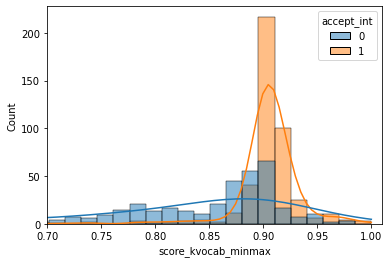

In [45]:
sns.histplot(data=test_set_scores, x='score_kvocab_minmax', hue='accept_int', kde=True)
_ = plt.xlim(0.7, 1.01)

In [24]:
test_set_scores.loc[test_set_scores['score_kvocab'] <= 0, :].groupby(by='accept_int')['score_kvocab'].describe().transpose()

accept_int,0,1
count,282.000000,33.000000
mean,-24.227387,-10.997487
std,25.678344,11.325401
min,-117.526086,-36.127015
25%,-38.363617,-18.799554
50%,-14.132060,-7.222708
75%,-4.457042,-1.353281
max,0.000000,0.000000


In [25]:
test_set_scores.loc[test_set_scores['score_kvocab'] > 0, :].groupby(by='accept_int')['score_kvocab'].describe().transpose()

accept_int,0,1
count,161.000000,408.000000
mean,3.607453,4.151960
std,2.552675,2.317842
min,0.112610,0.025516
25%,2.000000,2.824009
50%,2.766130,3.567613
75%,4.000000,4.767170
max,13.571336,16.162124


Best threshold: 0.88, f1_score: 0.8075396825396824, precission: 0.7178130511463845, recall: 0.9229024943310657


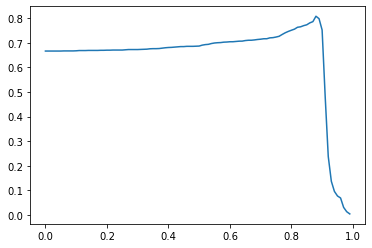

In [116]:
y_true = test_set_scores['accept_int'].values.reshape(-1, 1)
score_kvocab = test_set_scores['score_kvocab'].values.reshape(-1, 1)

best_threshold_score_kvocab = score_threshold(y_true, score_kvocab, scaler='minmax')

              precision    recall  f1-score   support

           0       0.89      0.64      0.74       443
           1       0.72      0.92      0.81       441

    accuracy                           0.78       884
   macro avg       0.81      0.78      0.78       884
weighted avg       0.81      0.78      0.78       884



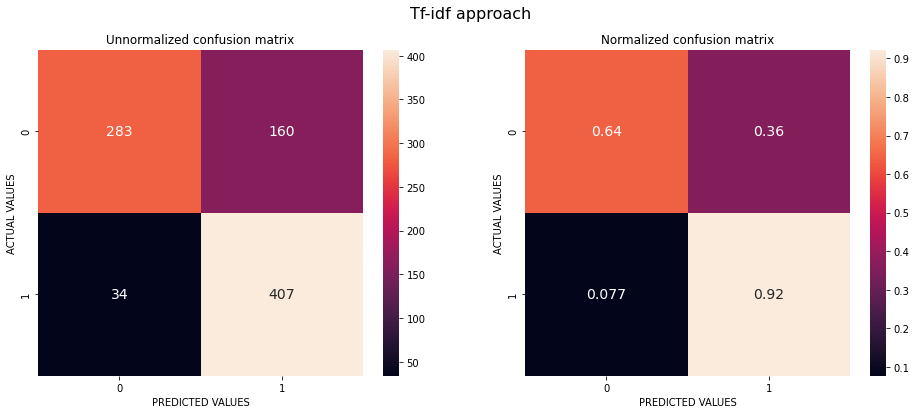

{'accuracy': 0.7805429864253394,
 'precision': 0.7178130511463845,
 'recall': 0.9229024943310657,
 'f1': 0.8075396825396824}

In [128]:
evaluate_results(y_true, test_set_scores['score_kvocab_minmax'].values.reshape(-1, 1), threshold=0.88, title='Tf-idf approach')

In [125]:
test_set_scores['score_kvocab_predict'] = np.where(score_kvocab > best_threshold_score_kvocab, 1, 0)

fp_mask = (test_set_scores['accept_int'] == 0) & (test_set_scores['score_kvocab_predict'] == 1)

In [126]:
fp_mask.sum()

157

<AxesSubplot:>

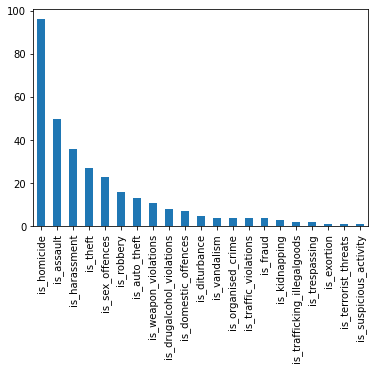

In [118]:
grouped = test_df_counts.loc[fp_mask, ['is_' + cat for cat in fltr.relevant_categories_names]]
grouped.apply(np.sum).sort_values(ascending=False).plot(kind='bar')

<AxesSubplot:>

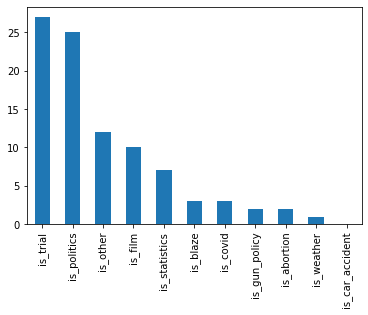

In [119]:
grouped = df_filter.loc[fp_mask, ['is_' + cat for cat in fltr.not_relevant_categories_names]]
grouped.apply(np.sum).sort_values(ascending=False).plot(kind='bar')

In [127]:
test_set_scores[fp_mask]

,text,accept,accept_int,score_kvocab,score_kvocab_minmax,score_kvocab_predict
17,"President Joe Biden is ""not cognitively presen...",['NOT-RELEVANT'],0,2.000000,0.894066,1
31,Kate Winslet was taken to the hospital after s...,['NOT-RELEVANT'],0,2.826210,0.900246,1
42,Due to a large drought Las Vegas' Lake Mead ha...,['NOT-RELEVANT'],0,2.000000,0.894066,1
57,Reported By: | |Source: DNA webdesk |Updated: ...,['NOT-RELEVANT'],0,1.890609,0.893248,1
65,A 25-year-old OnlyFans model and social media ...,['NOT-RELEVANT'],0,4.664602,0.913997,1
70,"HUTCHINSON, Kan. (AP) -- A former police offic...",['NOT-RELEVANT'],0,12.532655,0.972851,1
76,"A local constable, who was also a U.S. Army ve...",['NOT-RELEVANT'],0,3.684358,0.906665,1
79,Weekdays 6:00AM - 10:00AM Loren honors a falle...,['NOT-RELEVANT'],0,2.000000,0.894066,1
90,Zachary Levi made a name for himself on televi...,['NOT-RELEVANT'],0,1.000000,0.886586,1
94,"Load Error MONONGALIA COUNTY, W.Va. - A man wa...",['NOT-RELEVANT'],0,2.205600,0.895604,1


In [122]:
nlp = spacy.blank('en')
new_ruler = nlp.add_pipe("entity_ruler").from_disk(os.path.join(PATH_TO_PATTERNS, 'basic-patterns.jsonl'))

false_pos = pd.concat([test_set_scores, test_df_counts], axis=1)[fp_mask]
print(f"There are {false_pos.shape[0]} false pos\n")

for name in fltr.not_relevant_categories_names:
    subset_mask = false_pos['is_' + name] == 1
    print(f"There are {subset_mask.sum()} fp in {name}")
    
    for i, idx in enumerate(false_pos[subset_mask].index):
        print(i+1, f'index {idx}')
        doc = nlp(false_pos.loc[idx, 'text'])
        displacy.render(doc, style="ent")
        print('-'*150)

There are 157 false pos

There are 27 fp in trial
1 index 94


------------------------------------------------------------------------------------------------------------------------------------------------------
2 index 98


------------------------------------------------------------------------------------------------------------------------------------------------------
3 index 141


------------------------------------------------------------------------------------------------------------------------------------------------------
4 index 278


------------------------------------------------------------------------------------------------------------------------------------------------------
5 index 300


------------------------------------------------------------------------------------------------------------------------------------------------------
6 index 325


------------------------------------------------------------------------------------------------------------------------------------------------------
7 index 334


------------------------------------------------------------------------------------------------------------------------------------------------------
8 index 340


------------------------------------------------------------------------------------------------------------------------------------------------------
9 index 341


------------------------------------------------------------------------------------------------------------------------------------------------------
10 index 343


------------------------------------------------------------------------------------------------------------------------------------------------------
11 index 364


------------------------------------------------------------------------------------------------------------------------------------------------------
12 index 368


------------------------------------------------------------------------------------------------------------------------------------------------------
13 index 380


------------------------------------------------------------------------------------------------------------------------------------------------------
14 index 384


------------------------------------------------------------------------------------------------------------------------------------------------------
15 index 394


------------------------------------------------------------------------------------------------------------------------------------------------------
16 index 397


------------------------------------------------------------------------------------------------------------------------------------------------------
17 index 404


------------------------------------------------------------------------------------------------------------------------------------------------------
18 index 405


------------------------------------------------------------------------------------------------------------------------------------------------------
19 index 407


------------------------------------------------------------------------------------------------------------------------------------------------------
20 index 427


------------------------------------------------------------------------------------------------------------------------------------------------------
21 index 433


------------------------------------------------------------------------------------------------------------------------------------------------------
22 index 443


------------------------------------------------------------------------------------------------------------------------------------------------------
23 index 469


------------------------------------------------------------------------------------------------------------------------------------------------------
24 index 487


------------------------------------------------------------------------------------------------------------------------------------------------------
25 index 509


------------------------------------------------------------------------------------------------------------------------------------------------------
26 index 593


------------------------------------------------------------------------------------------------------------------------------------------------------
27 index 917


------------------------------------------------------------------------------------------------------------------------------------------------------
There are 0 fp in car_accident
There are 7 fp in statistics
1 index 131


------------------------------------------------------------------------------------------------------------------------------------------------------
2 index 297


------------------------------------------------------------------------------------------------------------------------------------------------------
3 index 312


------------------------------------------------------------------------------------------------------------------------------------------------------
4 index 327


------------------------------------------------------------------------------------------------------------------------------------------------------
5 index 390


------------------------------------------------------------------------------------------------------------------------------------------------------
6 index 421


------------------------------------------------------------------------------------------------------------------------------------------------------
7 index 423


------------------------------------------------------------------------------------------------------------------------------------------------------
There are 2 fp in gun_policy
1 index 395


------------------------------------------------------------------------------------------------------------------------------------------------------
2 index 437


------------------------------------------------------------------------------------------------------------------------------------------------------
There are 2 fp in abortion
1 index 98


------------------------------------------------------------------------------------------------------------------------------------------------------
2 index 425


------------------------------------------------------------------------------------------------------------------------------------------------------
There are 25 fp in politics
1 index 17


------------------------------------------------------------------------------------------------------------------------------------------------------
2 index 57


------------------------------------------------------------------------------------------------------------------------------------------------------
3 index 98


------------------------------------------------------------------------------------------------------------------------------------------------------
4 index 104


------------------------------------------------------------------------------------------------------------------------------------------------------
5 index 181


------------------------------------------------------------------------------------------------------------------------------------------------------
6 index 279


------------------------------------------------------------------------------------------------------------------------------------------------------
7 index 302


------------------------------------------------------------------------------------------------------------------------------------------------------
8 index 311


------------------------------------------------------------------------------------------------------------------------------------------------------
9 index 325


------------------------------------------------------------------------------------------------------------------------------------------------------
10 index 374


------------------------------------------------------------------------------------------------------------------------------------------------------
11 index 378


------------------------------------------------------------------------------------------------------------------------------------------------------
12 index 388


------------------------------------------------------------------------------------------------------------------------------------------------------
13 index 390


------------------------------------------------------------------------------------------------------------------------------------------------------
14 index 397


------------------------------------------------------------------------------------------------------------------------------------------------------
15 index 398


------------------------------------------------------------------------------------------------------------------------------------------------------
16 index 401


------------------------------------------------------------------------------------------------------------------------------------------------------
17 index 429


------------------------------------------------------------------------------------------------------------------------------------------------------
18 index 433


------------------------------------------------------------------------------------------------------------------------------------------------------
19 index 442


------------------------------------------------------------------------------------------------------------------------------------------------------
20 index 459


------------------------------------------------------------------------------------------------------------------------------------------------------
21 index 463


------------------------------------------------------------------------------------------------------------------------------------------------------
22 index 469


------------------------------------------------------------------------------------------------------------------------------------------------------
23 index 474


------------------------------------------------------------------------------------------------------------------------------------------------------
24 index 593


------------------------------------------------------------------------------------------------------------------------------------------------------
25 index 600


------------------------------------------------------------------------------------------------------------------------------------------------------
There are 3 fp in blaze
1 index 468


------------------------------------------------------------------------------------------------------------------------------------------------------
2 index 489


------------------------------------------------------------------------------------------------------------------------------------------------------
3 index 601


------------------------------------------------------------------------------------------------------------------------------------------------------
There are 10 fp in film
1 index 31


------------------------------------------------------------------------------------------------------------------------------------------------------
2 index 260


------------------------------------------------------------------------------------------------------------------------------------------------------
3 index 326


------------------------------------------------------------------------------------------------------------------------------------------------------
4 index 338


------------------------------------------------------------------------------------------------------------------------------------------------------
5 index 349


------------------------------------------------------------------------------------------------------------------------------------------------------
6 index 403


------------------------------------------------------------------------------------------------------------------------------------------------------
7 index 413


------------------------------------------------------------------------------------------------------------------------------------------------------
8 index 431


------------------------------------------------------------------------------------------------------------------------------------------------------
9 index 490


------------------------------------------------------------------------------------------------------------------------------------------------------
10 index 608


------------------------------------------------------------------------------------------------------------------------------------------------------
There are 1 fp in weather
1 index 127


------------------------------------------------------------------------------------------------------------------------------------------------------
There are 3 fp in covid
1 index 191


------------------------------------------------------------------------------------------------------------------------------------------------------
2 index 366


------------------------------------------------------------------------------------------------------------------------------------------------------
3 index 403


------------------------------------------------------------------------------------------------------------------------------------------------------
There are 12 fp in other
1 index 57


------------------------------------------------------------------------------------------------------------------------------------------------------
2 index 90


------------------------------------------------------------------------------------------------------------------------------------------------------
3 index 142


------------------------------------------------------------------------------------------------------------------------------------------------------
4 index 160


------------------------------------------------------------------------------------------------------------------------------------------------------
5 index 332


------------------------------------------------------------------------------------------------------------------------------------------------------
6 index 353


------------------------------------------------------------------------------------------------------------------------------------------------------
7 index 360


------------------------------------------------------------------------------------------------------------------------------------------------------
8 index 368


------------------------------------------------------------------------------------------------------------------------------------------------------
9 index 369


------------------------------------------------------------------------------------------------------------------------------------------------------
10 index 386


------------------------------------------------------------------------------------------------------------------------------------------------------
11 index 399


------------------------------------------------------------------------------------------------------------------------------------------------------
12 index 530


------------------------------------------------------------------------------------------------------------------------------------------------------


In [137]:
tfidf = vocab_vectorizer.transform([" ".join(vocab)]).toarray()
v = dict(zip(vocab, np.squeeze(tfidf)))
dict(sorted(v.items(), key=lambda item: item[1], reverse=True))

{'theft': 0.2869158811081496,
 'stole': 0.22452208371450166,
 'narcotics': 0.17489083013373294,
 'drugs': 0.15406498110989728,
 'shots': 0.1481212496945632,
 'extradicted': 0.14625342094496369,
 'vehicle theft': 0.14042212080466795,
 'disturbance': 0.13988521408856006,
 'tracking': 0.13818879878832083,
 'stole car': 0.12756536357044984,
 'hit run': 0.1152091229903755,
 'motor vehicle theft': 0.10033469362571741,
 'burglary': 0.0979926286341496,
 'extortion': 0.09315887216746085,
 'assault': 0.09215915269928757,
 'weapon': 0.09031020832121057,
 'threatening': 0.08917796983011855,
 'intrusion': 0.0855781602289078,
 'larceny': 0.08479095536101844,
 'robbery': 0.08285221510656045,
 'beating man': 0.08161585436812004,
 'abortion law': 0.08001814380100072,
 'fraud': 0.06983041436986445,
 'crime index rate': 0.0691905204185175,
 'one-in-10': 0.0691905204185175,
 'property crime index': 0.0691905204185175,
 'tops chart': 0.0691905204185175,
 'intrusion plates': 0.0691905204185175,
 'upper brac

## Apply base-filter

In [46]:
# df storing results of experiments
experiments_df = pd.DataFrame(columns=['name', 'accuracy', 'precision', 'recall', 'f1', 'y_pred', 'weights', 'threshold'])
experiments_df.head()

,name,accuracy,precision,recall,f1,y_pred,weights,threshold


In [47]:
with timer(f'Filtering {test_set_df.shape[0]} entries'):
    df_filter = base_filter_for_dataframe(test_set_df)

[13:43:10] INFO generic-utils: Filtering 884 entries - done in 3s


In [48]:
df_filter.head()

,text,accept,accept_int,harassment_body,is_harassment,theft_body,is_theft,robbery_body,is_robbery,auto_theft_body,is_auto_theft,assault_body,is_assault,exortion_body,is_exortion,kidnapping_body,is_kidnapping,sex_offences_body,is_sex_offences,vandalism_body,is_vandalism,trafficking_illegalgoods_body,is_trafficking_illegalgoods,fraud_body,is_fraud,organised_crime_body,is_organised_crime,homicide_body,is_homicide,terrorist_threats_body,is_terrorist_threats,diturbance_body,is_diturbance,suspicious_activity_body,is_suspicious_activity,domestic_offences_body,is_domestic_offences,drugalcohol_violations_body,is_drugalcohol_violations,traffic_violations_body,is_traffic_violations,trespassing_body,is_trespassing,weapon_violations_body,is_weapon_violations,trial_body,is_trial,car_accident_body,is_car_accident,statistics_body,is_statistics,gun_policy_body,is_gun_policy,abortion_body,is_abortion,politics_body,is_politics,blaze_body,is_blaze,film_body,is_film,weather_body,is_weather,covid_body,is_covid,other_body,is_other,has_relevant_words,has_not_relevant_words,base_filter,base_filter_int
0,Two people died when their van crashed into a ...,['NOT-RELEVANT'],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[killed],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,"[crash, crashed]",1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,1,1,NOT_RELEVANT,0
1,CUMBERLAND -- Information is being sought to i...,['RELEVANT'],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[arson],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,1,0,RELEVANT,1
2,Flossmoor police officers fatally shot a woman...,['RELEVANT'],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,"[fatally shot, shooting, shot]",1,[],0,[domestic disturbance],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,1,0,RELEVANT,1
3,"PALMER, PA- The Palmer Township Police respond...",['RELEVANT'],1,[harassment],1,[],0,[],0,[],0,"[aggravated assault, assault, simple assault]",1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[disorderly conduct],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,1,0,RELEVANT,1
4,The Georgia Bureau of Investigation said a man...,['RELEVANT'],1,[],0,[],0,[],0,[stolen vehicle],1,[injured],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[shot],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,1,0,RELEVANT,1


In [ ]:
#with timer(f'Filtering {df_prep.shape[0]} entries'):
#    df_prep['base_filter'] = df_prep['text'].apply(base_filter)

In [ ]:
#df_prep['base_filter_int'] = (df_prep['base_filter'] == 'RELEVANT').astype(int)
#df_prep.head()

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       443
           1       0.83      0.84      0.84       441

    accuracy                           0.83       884
   macro avg       0.83      0.83      0.83       884
weighted avg       0.83      0.83      0.83       884



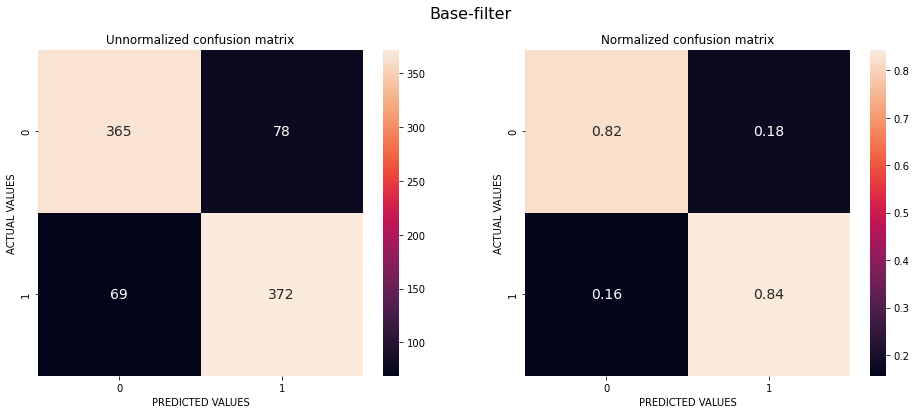

In [49]:
y_true = df_filter['accept_int'].values.reshape(-1, 1)
y_pred = df_filter['base_filter_int'].values.reshape(-1, 1)

base_filter_res = evaluate_results(y_true, y_pred, title='Base-filter')
base_filter_res['name'] = 'Base-filter'
base_filter_res['y_pred'] = y_pred

In [ ]:
for name in fltr.not_relevant_categories_names:
    mask = df_filter['is_' + name] == 1
    subset = df_filter[mask]
    
    y_true = subset['accept_int'].values.reshape(-1, 1)
    y_pred = subset['base_filter_int'].values.reshape(-1, 1)

    evaluate_results(y_true, y_pred, title=f'Base-filter {name} subset')

In [50]:
experiments_df = experiments_df.append(base_filter_res, ignore_index=True)
experiments_df.head()

,name,accuracy,precision,recall,f1,y_pred,weights,threshold
0,Base-filter,0.83371,0.826667,0.843537,0.835017,"[[0], [1], [1], [1], [1], [0], [0], [0], [1], ...",NaN,NaN


In [51]:
df_filter.groupby(by=['accept_int', 'base_filter_int']).agg({'text': 'count', 'is_trial': 'sum'})

text  is_trial
accept_int base_filter_int                
0          0                 365       182
           1                  78         0
1          0                  69        36
           1                 372         0

## Analyze false negatives

<AxesSubplot:>

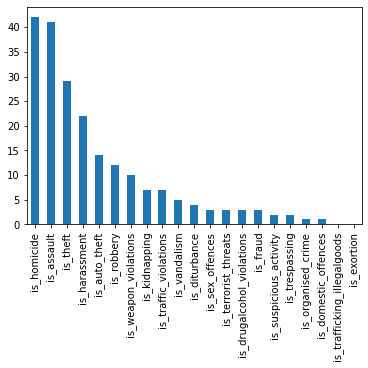

In [99]:
fn_mask = (df_filter['accept_int'] == 1) & (df_filter['base_filter_int'] == 0)

grouped = df_filter.loc[fn_mask, ['is_' + cat for cat in fltr.relevant_categories_names]]
grouped.apply(np.sum).sort_values(ascending=False).plot(kind='bar')

In [ ]:
grouped = df_filter.loc[fn_mask, ['is_' + cat for cat in fltr.not_relevant_categories_names]]
grouped.apply(np.sum).sort_values(ascending=False).plot(kind='bar')

In [ ]:
columns = ['text'] + ['is_' + cat for cat in fltr.not_relevant_categories_names] + [cat + '_body' for cat in fltr.not_relevant_categories_names]
grouped = df_filter.loc[fn_mask, columns]

for cat in [cat + '_body' for cat in fltr.not_relevant_categories_names]:
    print(grouped[cat].astype(str).value_counts().head())
    print('\n'+'-'*30+'\n')

In [ ]:
nlp = spacy.blank('en')
new_ruler = nlp.add_pipe("entity_ruler").from_disk(os.path.join(PATH_TO_PATTERNS, 'basic-patterns.jsonl'))

false_neg = df_filter[fn_mask]
print(f"There are {false_neg.shape[0]} false negatives\n")

for name in fltr.not_relevant_categories_names:
    subset_mask = false_neg['is_' + name] == 1
    print(f"There are {subset_mask.sum()} fn in {name}")
    
    for i, idx in enumerate(false_neg[subset_mask].index):
        print(i+1, f'index {idx}')
        doc = nlp(false_neg.loc[idx, 'text'])
        displacy.render(doc, style="ent")
        print('-'*150)

## Analyzing false positives

In [ ]:
fp_mask = (df_filter['accept_int'] == 0) & (df_filter['base_filter_int'] == 1)

grouped = df_filter.loc[fp_mask, ['is_' + cat for cat in fltr.relevant_categories_names]]
grouped.apply(np.sum).sort_values(ascending=False).plot(kind='bar')

In [ ]:
grouped = df_filter.loc[fp_mask, ['is_' + cat for cat in fltr.not_relevant_categories_names]]
grouped.apply(np.sum).sort_values(ascending=False).plot(kind='bar')

In [ ]:
false_pos = df_filter[fp_mask]
print(f"There are {false_pos.shape[0]} false positives\n")

for name in fltr.relevant_categories_names:
    subset_mask = false_pos['is_' + name] == 1
    print(f"There are {subset_mask.sum()} fn in {name}")
    
    for i, idx in enumerate(false_pos[subset_mask].index):
        print(i+1, f'index {idx}')
        doc = nlp(false_pos.loc[idx, 'text'])
        displacy.render(doc, style="ent")
        print('-'*150)

# Advanced filter 1 (more complex logic than base-filter)

In [ ]:
def advanced_filter(df: pd.DataFrame) -> pd.DataFrame:
    def f(x):
        if (x[0] == 0 and x[2] == 1):
            return 1
        return 0
    
    strong_cols = [
        'trial', 'statistics', 'gun_policy',
        'abortion', 'politics', 'film',
        'weather', 'covid', 'other',
    ]
    
    weak_cols = ['blaze', 'car_accident']
    
    df['has_strong_not_rel'] = df[['is_' + name for name in strong_cols]].apply(any, axis=1).astype(int)
    df['has_weak_not_rel'] = df[['is_' + name for name in weak_cols]].apply(any, axis=1).astype(int)
    df['has_relevant'] = df[['is_' + cat for cat in fltr.relevant_categories_names]].apply(any, axis=1).astype(int)
    
    df['advanced_filter_int'] = df[['has_strong_not_rel', 'has_weak_not_rel', 'has_relevant']].apply(f, axis=1)
    return df

In [ ]:
with timer(f'Filtering {df_prep.shape[0]} entries'):
    df_filter_advanced = find_keywords_for_dataframe(df_prep)
    df_filter_advanced = advanced_filter(df_filter_advanced)

In [ ]:
df_filter_advanced.head()

In [ ]:
y_true = df_filter_advanced['accept_int'].values.reshape(-1, 1)
y_pred = df_filter_advanced['advanced_filter_int'].values.reshape(-1, 1)

advanced_fltr_res = evaluate_results(y_true, y_pred, title='Advanced-filter')
advanced_fltr_res['name'] = 'Advanced-filter'
advanced_fltr_res['y_pred'] = y_pred

In [ ]:
for name in fltr.not_relevant_categories_names:
    mask = df_filter_advanced['is_' + name] == 1
    subset = df_filter_advanced[mask]
    
    y_true = subset['accept_int'].values.reshape(-1, 1)
    y_pred = subset['advanced_filter_int'].values.reshape(-1, 1)

    evaluate_results(y_true, y_pred, title=f'Advanced-filter {name} subset')

In [ ]:
experiments_df = experiments_df.append(advanced_fltr_res, ignore_index=True)
experiments_df.head()

# Filter with weights

In [80]:
def weight_keywords_for_dataframe(df_input: pd.DataFrame, weights: Dict, unique: bool=True) -> pd.DataFrame:
    df = df_input.copy(deep=True)
    
    df['score'] = 0
    
    categories = weights.keys()
    regexes = fltr.relevant_regex_list + fltr.not_relevant_regex_list

    for category, regex in zip(categories, regexes):
        col_name = 'is_' + category
        body_name = category + '_body'
        df[body_name] = df['text'].str.lower().apply(lambda x: re.sub(fltr.PUNCTUATION_REGEX, " ", x) if isinstance(x, str) else x)
        df[body_name] = df[body_name].apply(regex.findall)
        if unique:
            df[body_name] = df[body_name].apply(lambda x: [x.strip() for x in sorted(set(x))])
        else:
            df[body_name] = df[body_name].apply(lambda x: [x.strip() for x in sorted(x)])
        df[col_name] = 0
        df.loc[df[body_name].astype(str) != '[]', col_name] = 1
        df['score'] += df[body_name].apply(len) * weights[category]

    return df

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def score_threshold(actual, scores, scaler, verbose=True):
    
    if scaler:
        if scaler == 'sigmoid':
            scaler = sigmoid
            scores = scaler(scores)
        elif scaler == 'minmax':
            scaler = preprocessing.MinMaxScaler()
            scaler.fit(scores)
            scores = scaler.transform(scores)
        else:
            raise ValueError("Wrong scaler")
        arange = np.arange(0, 1, 0.01)
    else:
        arange = np.arange(np.min(scores), np.max(scores))
 
    results = []
    
    for threshold in arange:
        y_pred = np.where(scores > threshold, 1, 0)
        f1_score = metrics.f1_score(actual, y_pred)
        results.append([threshold, f1_score])
    
    results = np.array(results)
    best_threshold = results[np.argmax(results[:, 1]), 0]
    y_pred_best = np.where(scores > best_threshold, 1, 0)
    
    if verbose:
        precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(actual, y_pred_best, average='binary')
        print(f'Best threshold: {best_threshold}, f1_score: {f1_score}, precission: {precision}, recall: {recall}')
        sns.lineplot(x=results[:, 0], y=results[:, 1])
    
    return best_threshold
    
def exract_count_features(df):
    categories = fltr.relevant_categories_names + fltr.not_relevant_categories_names
    result = df[[name + '_body' for name in categories]].apply(lambda x: [len(i) for i in x], axis=1)
    return np.array([*result.values])

def predict_with_weights(X, y_true, weights, scaler_type=None, name='Classifier', verbose=False):
    scores = np.dot(X, weights.T)
    
    if scaler_type:
        if scaler_type == 'sigmoid':
            scaler = sigmoid
            y_pred = scaler(scores)
        elif scaler_type == 'minmax':
            scores = scores.reshape(-1, 1)
            scaler = preprocessing.MinMaxScaler()
            scaler.fit(scores)
            y_pred = scaler.transform(scores)
        else:
            raise ValueError("Wrong scaler")
        #y_pred = scaler(scores)
    else:
        y_pred = scores

    y_pred = y_pred.reshape(1, -1)
    #print(y_pred.shape)
    best_threshold = score_threshold(y_true, scores, scaler_type, verbose=verbose)

    results = evaluate_results(y_true, y_pred, threshold=best_threshold, verbose=verbose)
    results['name'] = name
    results['weights'] = weights
    results['threshold'] = best_threshold
    results['y_pred'] = np.where(y_pred > best_threshold, 1, 0)

    return results

## In first approach try different weights and count only unique key words (using set)

In [53]:
rel_w = {
    'harassment': 4, 'theft': 5,
    'robbery': 7, 'auto_theft': 7,
    'assault': 7, 'exortion': 5,
    'kidnapping': 9, 'sex_offences': 9,
    'vandalism': 2, 'trafficking_illegalgoods': 4,
    'fraud': 2, 'organised_crime': 4,
    'homicide': 10, 'terrorist_threats': 1,
    'diturbance': 1, 'suspicious_activity': 1,
    'domestic_offences': 1, 'drugalcohol_violations': 1,
    'traffic_violations': 4, 'trespassing': 4,
    'weapon_violations': 3
}

not_rel_w = {
    'trial': -10,
    'car_accident': -5,
    'statistics': -6,
    'gun_policy': -15,
    'abortion': -7,
    'politics': -5,
    'blaze': -3,
    'film': -10,
    'weather': -10,
    'covid': -8,
    'other': -10
}

severity_weights = np.array([*rel_w.values(), *not_rel_w.values()])#.reshape(1, -1)

In [71]:
weights = []
for cat, weight in zip(fltr.all_key_words_list, severity_weights):
    weights += [weight] * len(cat)
    
np.array(weights).shape

(829,)

In [76]:
df_weights = find_keywords_for_dataframe(test_set_df, unique=True)

X = exract_count_features(df_weights)
y_true = df_weights['accept_int'].values#.reshape(-1, 1)

In [81]:
with timer("time taken"):
    severity_filter_no_scaler_res = predict_with_weights(X, y_true, severity_weights, name='Severity-filter-no-scaler', verbose=False)
    severity_filter_sigmoid_scaler_res = predict_with_weights(X, y_true, severity_weights, scaler_type='sigmoid', name='Severity-filter-sigmoid-scaler', verbose=False)
    severity_filter_minmax_scaler_res = predict_with_weights(X, y_true, severity_weights, scaler_type='minmax', name='Severity-filter-minmax-scaler', verbose=False)

(1, 884)
(1, 884)
(1, 884)
[14:44:21] INFO generic-utils: time taken - done in 0s


In [82]:
experiments_df = experiments_df.drop_duplicates(subset='name', keep=False)  
severiry_results = [severity_filter_no_scaler_res, severity_filter_sigmoid_scaler_res, severity_filter_minmax_scaler_res]
experiments_df = experiments_df.append(severiry_results, ignore_index=True)
experiments_df.sort_values(by='f1', ascending=False)

,name,accuracy,precision,recall,f1,y_pred,weights,threshold
0,Base-filter,0.833710,0.826667,0.843537,0.835017,"[[0], [1], [1], [1], [1], [0], [0], [0], [1], ...",NaN,NaN
1,Severity-filter-no-scaler,0.787330,0.716239,0.950113,0.816764,"[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,...","[4, 5, 7, 7, 7, 5, 9, 9, 2, 4, 2, 4, 10, 1, 1,...",6.00
3,Severity-filter-minmax-scaler,0.787330,0.716239,0.950113,0.816764,"[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,...","[4, 5, 7, 7, 7, 5, 9, 9, 2, 4, 2, 4, 10, 1, 1,...",0.43
2,Severity-filter-sigmoid-scaler,0.779412,0.701639,0.970522,0.814462,"[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,...","[4, 5, 7, 7, 7, 5, 9, 9, 2, 4, 2, 4, 10, 1, 1,...",0.99


In [ ]:
columns = [*experiments_df.loc[1:3, 'name'].values]
predictions = [*experiments_df.loc[1:3, 'y_pred'].values]

for col, pred in zip(columns, predictions):
    df_weights[col] = pred

In [ ]:
y_true = df_weights['accept_int'].values.reshape(-1, 1)
y_pred = experiments_df.loc[2, 'y_pred'].reshape(-1, 1)

advanced_fltr_res = evaluate_results(y_true, y_pred, title='Severity-filter')
#advanced_fltr_res['name'] = 'Advanced-filter'
#advanced_fltr_res['y_pred'] = y_pred

In [ ]:
fp_mask = (df_filter['accept_int'] == 0) & (df_filter['Severity-filter-minmax-scaler'] == 1)

grouped = df_filter.loc[fp_mask, ['is_' + cat for cat in fltr.relevant_categories_names]]
grouped.apply(np.sum).sort_values(ascending=False).plot(kind='bar')

In [ ]:
cols = [
    'is_homicide', 'is_assault', 'is_weapon_violations',
    'is_sex_offences', 'is_harassment', 'is_theft', 
    'is_robbery', 'is_auto_theft']

for name in cols:
    mask = df_prep[name] == 1
    subset = df_prep[mask]
    
    y_true = subset['accept_int'].values.reshape(-1, 1)
    y_pred = subset['Severity-filter-minmax-scaler'].values.reshape(-1, 1)

    evaluate_results(y_true, y_pred, title=f'Sevetity-filter {name} subset')

In [ ]:
fp_mask = (df_filter['accept_int'] == 0) & (df_filter['Severity-filter-minmax-scaler'] == 1)

grouped = df_filter.loc[fp_mask, ['is_' + cat for cat in fltr.not_relevant_categories_names]]
grouped.apply(np.sum).sort_values(ascending=False).plot(kind='bar')

In [ ]:
for name in fltr.not_relevant_categories_names:
    mask = df_prep['is_' + name] == 1
    subset = df_prep[mask]
    
    y_true = subset['accept_int'].values.reshape(-1, 1)
    y_pred = subset['Severity-filter-minmax-scaler'].values.reshape(-1, 1)

    evaluate_results(y_true, y_pred, title=f'Sevetity-filter {name} subset')

In [ ]:
for name in fltr.relevant_categories_names:
    mask = df_prep['is_' + name] == 1
    subset = df_prep[mask]
    
    y_true = subset['accept_int'].values.reshape(-1, 1)
    y_pred = subset['severity_filter_minmax_int'].values.reshape(-1, 1)

    evaluate_results(y_true, y_pred, title=f'Sevetity-filter {name} subset')

In [83]:
rel_w2 = {
    'harassment': 2, 'theft': 2,
    'robbery': 4, 'auto_theft': 2,
    'assault': 4, 'exortion': 5,
    'kidnapping': 9, 'sex_offences': 9,
    'vandalism': 2, 'trafficking_illegalgoods': 4,
    'fraud': 2, 'organised_crime': 4,
    'homicide': 4, 'terrorist_threats': 1,
    'diturbance': 1, 'suspicious_activity': 1,
    'domestic_offences': 1, 'drugalcohol_violations': 1,
    'traffic_violations': 4, 'trespassing': 4,
    'weapon_violations': 1
}

not_rel_w2 = {
    'trial': -50,
    'car_accident': -10,
    'statistics': -10,
    'gun_policy': -20,
    'abortion': -7,
    'politics': -10,
    'blaze': -3,
    'film': -10,
    'weather': -10,
    'covid': -8,
    'other': -15
}

severity_weights2 = np.array([*rel_w2.values(), *not_rel_w2.values()]).reshape(1, -1)

In [84]:
X = exract_count_features(df_weights)
y_true = df_weights['accept_int'].values

with timer("time taken"):
    severity_filter_no_scaler_res2 = predict_with_weights(X, y_true, severity_weights2, name='Severity-filter-no-scaler2', verbose=False)
    severity_filter_sigmoid_scaler_res2 = predict_with_weights(X, y_true, severity_weights2, scaler_type='sigmoid', name='Severity-filter-sigmoid-scaler2', verbose=False)
    severity_filter_minmax_scaler_res2 = predict_with_weights(X, y_true, severity_weights2, scaler_type='minmax', name='Severity-filter-minmax-scaler2', verbose=False)

(1, 884)
(1, 884)
(1, 884)
[14:45:28] INFO generic-utils: time taken - done in 0s


In [85]:
experiments_df = experiments_df.drop_duplicates(subset='name', keep=False)
severiry_results2 = [severity_filter_no_scaler_res2, severity_filter_sigmoid_scaler_res2, severity_filter_minmax_scaler_res2]
experiments_df = experiments_df.append(severiry_results2, ignore_index=True)
experiments_df.sort_values(by='f1', ascending=False)

,name,accuracy,precision,recall,f1,y_pred,weights,threshold
4,Severity-filter-no-scaler2,0.840498,0.808642,0.891156,0.847896,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2, 2, 4, 2, 4, 5, 9, 9, 2, 4, 2, 4, 4, 1, 1,...",1.00
5,Severity-filter-sigmoid-scaler2,0.840498,0.808642,0.891156,0.847896,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2, 2, 4, 2, 4, 5, 9, 9, 2, 4, 2, 4, 4, 1, 1,...",0.74
6,Severity-filter-minmax-scaler2,0.838235,0.804082,0.893424,0.846402,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2, 2, 4, 2, 4, 5, 9, 9, 2, 4, 2, 4, 4, 1, 1,...",0.89
0,Base-filter,0.833710,0.826667,0.843537,0.835017,"[[0], [1], [1], [1], [1], [0], [0], [0], [1], ...",NaN,NaN
1,Severity-filter-no-scaler,0.787330,0.716239,0.950113,0.816764,"[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,...","[4, 5, 7, 7, 7, 5, 9, 9, 2, 4, 2, 4, 10, 1, 1,...",6.00
3,Severity-filter-minmax-scaler,0.787330,0.716239,0.950113,0.816764,"[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,...","[4, 5, 7, 7, 7, 5, 9, 9, 2, 4, 2, 4, 10, 1, 1,...",0.43
2,Severity-filter-sigmoid-scaler,0.779412,0.701639,0.970522,0.814462,"[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,...","[4, 5, 7, 7, 7, 5, 9, 9, 2, 4, 2, 4, 10, 1, 1,...",0.99


In [ ]:
columns = [*experiments_df.loc[4:6, 'name'].values]
predictions = [*experiments_df.loc[4:6, 'y_pred'].values]

for col, pred in zip(columns, predictions):
    df_filter[col] = pred

In [ ]:
y_true = df_filter['accept_int'].values.reshape(-1, 1)
y_pred = df_filter['Severity-filter-no-scaler2'].values.reshape(-1, 1)

advanced_fltr_res = evaluate_results(y_true, y_pred, title='Severity-filter2')
#advanced_fltr_res['name'] = 'Advanced-filter'
#advanced_fltr_res['y_pred'] = y_pred

In [ ]:
fp_mask = (df_filter['accept_int'] == 0) & (df_filter['Severity-filter-no-scaler2'] == 1)

grouped = df_filter.loc[fp_mask, ['is_' + cat for cat in fltr.relevant_categories_names]]
grouped.apply(np.sum).sort_values(ascending=False).plot(kind='bar')

In [ ]:
sns.barplot(data=experiments_df, y='name', x='f1', orient='h')

In [86]:
rel_w3 = {
    'harassment': 2, 'theft': 2,
    'robbery': 4, 'auto_theft': 2,
    'assault': 2, 'exortion': 5,
    'kidnapping': 9, 'sex_offences': 9,
    'vandalism': 2, 'trafficking_illegalgoods': 4,
    'fraud': 2, 'organised_crime': 4,
    'homicide': 2, 'terrorist_threats': 1,
    'diturbance': 1, 'suspicious_activity': 1,
    'domestic_offences': 1, 'drugalcohol_violations': 1,
    'traffic_violations': 4, 'trespassing': 4,
    'weapon_violations': 0.2
}

not_rel_w3 = {
    'trial': -50,
    'car_accident': -10,
    'statistics': -10,
    'gun_policy': -20,
    'abortion': -7,
    'politics': -15,
    'blaze': -3,
    'film': -10,
    'weather': -10,
    'covid': -8,
    'other': -15
}

severity_weights3 = np.array([*rel_w3.values(), *not_rel_w3.values()]).reshape(1, -1)

In [87]:
X = exract_count_features(df_weights)
y_true = df_weights['accept_int'].values

with timer("time taken"):
    severity_filter_no_scaler_res3 = predict_with_weights(X, y_true, severity_weights3, name='Severity-filter-no-scaler3', verbose=False)
    severity_filter_sigmoid_scaler_res3 = predict_with_weights(X, y_true, severity_weights3, scaler_type='sigmoid', name='Severity-filter-sigmoid-scaler3', verbose=False)
    severity_filter_minmax_scaler_res3 = predict_with_weights(X, y_true, severity_weights3, scaler_type='minmax', name='Severity-filter-minmax-scaler3', verbose=False)

(1, 884)
(1, 884)
(1, 884)
[14:45:51] INFO generic-utils: time taken - done in 1s


In [88]:
experiments_df = experiments_df.drop_duplicates(subset='name', keep=False)
severiry_results3 = [severity_filter_no_scaler_res3, severity_filter_sigmoid_scaler_res3, severity_filter_minmax_scaler_res3]
experiments_df = experiments_df.append(severiry_results3, ignore_index=True)
experiments_df.sort_values(by='f1', ascending=False)

,name,accuracy,precision,recall,f1,y_pred,weights,threshold
7,Severity-filter-no-scaler3,0.846154,0.825160,0.877551,0.850549,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2.0, 2.0, 4.0, 2.0, 2.0, 5.0, 9.0, 9.0, 2.0,...",0.00
8,Severity-filter-sigmoid-scaler3,0.846154,0.825160,0.877551,0.850549,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2.0, 2.0, 4.0, 2.0, 2.0, 5.0, 9.0, 9.0, 2.0,...",0.50
4,Severity-filter-no-scaler2,0.840498,0.808642,0.891156,0.847896,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2, 2, 4, 2, 4, 5, 9, 9, 2, 4, 2, 4, 4, 1, 1,...",1.00
5,Severity-filter-sigmoid-scaler2,0.840498,0.808642,0.891156,0.847896,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2, 2, 4, 2, 4, 5, 9, 9, 2, 4, 2, 4, 4, 1, 1,...",0.74
9,Severity-filter-minmax-scaler3,0.842760,0.825431,0.868481,0.846409,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2.0, 2.0, 4.0, 2.0, 2.0, 5.0, 9.0, 9.0, 2.0,...",0.90
6,Severity-filter-minmax-scaler2,0.838235,0.804082,0.893424,0.846402,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2, 2, 4, 2, 4, 5, 9, 9, 2, 4, 2, 4, 4, 1, 1,...",0.89
0,Base-filter,0.833710,0.826667,0.843537,0.835017,"[[0], [1], [1], [1], [1], [0], [0], [0], [1], ...",NaN,NaN
1,Severity-filter-no-scaler,0.787330,0.716239,0.950113,0.816764,"[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,...","[4, 5, 7, 7, 7, 5, 9, 9, 2, 4, 2, 4, 10, 1, 1,...",6.00
3,Severity-filter-minmax-scaler,0.787330,0.716239,0.950113,0.816764,"[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,...","[4, 5, 7, 7, 7, 5, 9, 9, 2, 4, 2, 4, 10, 1, 1,...",0.43
2,Severity-filter-sigmoid-scaler,0.779412,0.701639,0.970522,0.814462,"[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,...","[4, 5, 7, 7, 7, 5, 9, 9, 2, 4, 2, 4, 10, 1, 1,...",0.99


## Now try same weights but without set

In [90]:
#df_weights_unique = find_keywords_for_dataframe(test_set_df, unique=True)
df_weights = find_keywords_for_dataframe(test_set_df, unique=False)

In [91]:
df_weights.head()

,text,accept,accept_int,harassment_body,is_harassment,theft_body,is_theft,robbery_body,is_robbery,auto_theft_body,is_auto_theft,assault_body,is_assault,exortion_body,is_exortion,kidnapping_body,is_kidnapping,sex_offences_body,is_sex_offences,vandalism_body,is_vandalism,trafficking_illegalgoods_body,is_trafficking_illegalgoods,fraud_body,is_fraud,organised_crime_body,is_organised_crime,homicide_body,is_homicide,terrorist_threats_body,is_terrorist_threats,diturbance_body,is_diturbance,suspicious_activity_body,is_suspicious_activity,domestic_offences_body,is_domestic_offences,drugalcohol_violations_body,is_drugalcohol_violations,traffic_violations_body,is_traffic_violations,trespassing_body,is_trespassing,weapon_violations_body,is_weapon_violations,trial_body,is_trial,car_accident_body,is_car_accident,statistics_body,is_statistics,gun_policy_body,is_gun_policy,abortion_body,is_abortion,politics_body,is_politics,blaze_body,is_blaze,film_body,is_film,weather_body,is_weather,covid_body,is_covid,other_body,is_other,has_relevant_words,has_not_relevant_words
0,Two people died when their van crashed into a ...,['NOT-RELEVANT'],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[killed],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,"[crash, crash, crash, crashed, crashed]",1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,1,1
1,CUMBERLAND -- Information is being sought to i...,['RELEVANT'],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[arson],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,1,0
2,Flossmoor police officers fatally shot a woman...,['RELEVANT'],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,"[fatally shot, shooting, shot]",1,[],0,[domestic disturbance],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,1,0
3,"PALMER, PA- The Palmer Township Police respond...",['RELEVANT'],1,[harassment],1,[],0,[],0,[],0,"[aggravated assault, assault, simple assault]",1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[disorderly conduct],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,1,0
4,The Georgia Bureau of Investigation said a man...,['RELEVANT'],1,[],0,[],0,[],0,[stolen vehicle],1,[injured],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[shot],1,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,[],0,1,0


In [92]:
X = exract_count_features(df_weights)
y_true = df_weights['accept_int'].values

with timer("time taken"):
    severity_filter_no_scaler_no_unique_res3 = predict_with_weights(X, y_true, severity_weights3, name='Severity-filter-no-scaler-no-unique3', verbose=False)
    severity_filter_sigmoid_scaler_no_unique_res3 = predict_with_weights(X, y_true, severity_weights3, scaler_type='sigmoid', name='Severity-filter-sigmoid-scaler-no-unique3', verbose=False)
    severity_filter_minmax_scaler_no_unique_res3 = predict_with_weights(X, y_true, severity_weights3, scaler_type='minmax', name='Severity-filter-minmax-scaler-no-unique3', verbose=False)

(1, 884)
(1, 884)
(1, 884)
[14:47:09] INFO generic-utils: time taken - done in 1s


In [93]:
experiments_df = experiments_df.drop_duplicates(subset='name', keep=False)
severiry_results_no_unique3 = [severity_filter_no_scaler_no_unique_res3, severity_filter_sigmoid_scaler_no_unique_res3, severity_filter_minmax_scaler_no_unique_res3]
experiments_df = experiments_df.append(severiry_results_no_unique3, ignore_index=True)
experiments_df.sort_values(by='f1', ascending=False)

,name,accuracy,precision,recall,f1,y_pred,weights,threshold
10,Severity-filter-no-scaler-no-unique3,0.854072,0.849776,0.859410,0.854566,"[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2.0, 2.0, 4.0, 2.0, 2.0, 5.0, 9.0, 9.0, 2.0,...",2.00
11,Severity-filter-sigmoid-scaler-no-unique3,0.854072,0.849776,0.859410,0.854566,"[[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2.0, 2.0, 4.0, 2.0, 2.0, 5.0, 9.0, 9.0, 2.0,...",0.89
7,Severity-filter-no-scaler3,0.846154,0.825160,0.877551,0.850549,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2.0, 2.0, 4.0, 2.0, 2.0, 5.0, 9.0, 9.0, 2.0,...",0.00
8,Severity-filter-sigmoid-scaler3,0.846154,0.825160,0.877551,0.850549,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2.0, 2.0, 4.0, 2.0, 2.0, 5.0, 9.0, 9.0, 2.0,...",0.50
4,Severity-filter-no-scaler2,0.840498,0.808642,0.891156,0.847896,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2, 2, 4, 2, 4, 5, 9, 9, 2, 4, 2, 4, 4, 1, 1,...",1.00
5,Severity-filter-sigmoid-scaler2,0.840498,0.808642,0.891156,0.847896,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2, 2, 4, 2, 4, 5, 9, 9, 2, 4, 2, 4, 4, 1, 1,...",0.74
9,Severity-filter-minmax-scaler3,0.842760,0.825431,0.868481,0.846409,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2.0, 2.0, 4.0, 2.0, 2.0, 5.0, 9.0, 9.0, 2.0,...",0.90
6,Severity-filter-minmax-scaler2,0.838235,0.804082,0.893424,0.846402,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2, 2, 4, 2, 4, 5, 9, 9, 2, 4, 2, 4, 4, 1, 1,...",0.89
0,Base-filter,0.833710,0.826667,0.843537,0.835017,"[[0], [1], [1], [1], [1], [0], [0], [0], [1], ...",NaN,NaN
12,Severity-filter-minmax-scaler-no-unique3,0.817873,0.771318,0.902494,0.831766,"[[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,...","[[2.0, 2.0, 4.0, 2.0, 2.0, 5.0, 9.0, 9.0, 2.0,...",0.85


In [ ]:
df_weights['homicide_body'].astype(str).value_counts().head()

In [ ]:
def category_stats(df: pd.DataFrame, category: str) -> pd.DataFrame:  
    relevant_mask = (df['homicide_body'].astype(str) != '[]') & (df['accept_int'] == 1)
    not_relevant_mask = (df['homicide_body'].astype(str) != '[]') & (df['accept_int'] == 0)
    
    relevant_words = [word for sublist in df.loc[relevant_mask, category + '_body'].values for word in sublist]
    relevant_counter = Counter(relevant_words)
    
    not_relevant_words = [word for sublist in df.loc[not_relevant_mask, category + '_body'].values for word in sublist]
    not_relevant_counter = Counter(not_relevant_words)
    
    data = []
    keys = list(set(relevant_counter.keys()).union(set(not_relevant_counter.keys())))
    for key in keys:
        rel_ratio = relevant_counter[key] / (relevant_counter[key] + not_relevant_counter[key])
        not_rel_ratio = not_relevant_counter[key] / (relevant_counter[key] + not_relevant_counter[key])
        data.append((key, rel_ratio, not_rel_ratio))
        
    return pd.DataFrame(data, columns=['key_word', 'rel_ratio', 'not_rel_ratio'])

In [ ]:
category_stats(df_weights, 'homicide').sort_values(by='not_rel_ratio', ascending=False)

In [ ]:
res['rel_ratio'].sum()

In [ ]:
res_unique = pd.DataFrame(columns=['key_word', 'rel_ratio_unique'])

for name in fltr.relevant_categories_names:
    cat_stats = category_stats(df_weights_unique, name).rename(columns={'rel_ratio': 'rel_ratio_unique'})
    res_unique = pd.concat([res_unique, cat_stats.loc[cat_stats['rel_ratio_unique'] < 0.5, ['key_word', 'rel_ratio_unique']]])
    
#res.sort_values('rel_ratio', ascending=False)
res_unique

In [ ]:
res_nunique = pd.DataFrame(columns=['key_word', 'rel_ratio_nunique'])

for name in fltr.relevant_categories_names:
    cat_stats = category_stats(df_weights, name).rename(columns={'rel_ratio': 'rel_ratio_nunique'})
    res_nunique = pd.concat([res_nunique, cat_stats.loc[cat_stats['rel_ratio_nunique'] < 0.5, ['key_word', 'rel_ratio_nunique']]])
    
#res.sort_values('rel_ratio', ascending=False)
res_nunique

In [ ]:
merged = pd.merge(res_unique, res_nunique, on=['key_word'])
merged['diff'] = np.abs(merged['rel_ratio_unique'] - merged['rel_ratio_nunique'])
merged.sort_values(by='diff', ascending=False)

In [ ]:
(merged['rel_ratio_nunique'] < 0.5).sum()

In [ ]:
res_nunique_not_rel = pd.DataFrame(columns=['key_word', 'not_rel_ratio_nunique'])

for name in fltr.not_relevant_categories_names:
    cat_stats = category_stats(df_weights, name).rename(columns={'not_rel_ratio': 'not_rel_ratio_nunique'})
    res_nunique_not_rel = pd.concat([res_nunique_not_rel, cat_stats.loc[cat_stats['not_rel_ratio_nunique'] < 0.5, ['key_word', 'not_rel_ratio_nunique']]])
    
#res.sort_values('rel_ratio', ascending=False)
res_nunique_not_rel

In [ ]:
sorted([word for sublist in fltr.relevant_key_words_list for word in sublist], key=len, reverse=True)

In [ ]:
counter['killed']

In [ ]:
from collections import Counter 
mask = df_weights['homicide_body'].astype(str) != '[]'

words = [word for sublist in df_weights.loc[mask, 'homicide_body'].values for word in sublist]
counter = Counter(words)

In [ ]:
mask2 = (df_weights['homicide_body'].astype(str) != '[]') & (df_weights['accept_int'] == 1)
words2 = [word for sublist in df_weights.loc[mask2, 'homicide_body'].values for word in sublist]
counter2 = Counter(words2)

In [ ]:
f = lambda c1, c2: {c1_item[0]: c1_item[1]/c2_item[1] for c1_item, c2_item in zip(c1, c2)}

In [ ]:
f(counter2.most_common(), counter.most_common())

In [ ]:
counter2.most_common()

In [ ]:
counter.most_common()

In [ ]:
from sklearn.linear_model import LogisticRegression

X_set = exract_count_features(df_filter)
#X_no_set = exract_count_features(df_weights)

#X = np.hstack([X_set, X_no_set])

lr = LogisticRegression().fit(X_set, y_true)
lr.score(X_set, y_true)

In [ ]:
evaluate_results(y_true, lr.predict(X).reshape(-1, 1), title='Logistic regression')

In [ ]:
score_threshold(y_true, lr.predict_proba(X)[:, 1], scaler='sigmoid')

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = exract_count_features(df_filter)
y_true = df_weights['accept_int'].values

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y_true)

In [ ]:
clf.score(X, y_true), clf.

In [ ]:
evaluate_results(y_true, clf.predict(X).reshape(-1, 1), title='SVC')

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X)

X_transformed = pca.transform(X)

In [ ]:
_, ax = plt.subplots(figsize=(16, 9))
sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=y_true, ax=ax)

In [ ]:
df_filter

In [ ]:
mask = df_prep['has_relevant_words'] == 1
df_prep.loc[mask, [name + '_body' for name in fltr.relevant_categories_names]].apply(np.hstack, axis=1).astype(str).value_counts()

In [ ]:
df_weights.groupby(by='accept_int').agg({'score': ['min', 'max', 'mean', 'median']})

In [ ]:
sns.histplot(data=df_weights, x='score', hue='accept_int')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
df_weights['score_min_max'] = min_max_scaler.fit_transform(df_weights['score'].values.reshape(-1, 1))

In [ ]:
sns.histplot(data=df_weights, x='score_min_max', hue='accept_int', stat='density')

In [ ]:
score_threshold(df_weights['accept_int'], df_weights['score'])

In [ ]:
min_max_scaler = MinMaxScaler()
df_weights['score_min_max'] = min_max_scaler.fit_transform(df_weights['score'].values.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_weights, x='score', y='score_min_max', hue='accept_int', ax=ax)

In [ ]:
df_weights['score_sigmoid'] = sigmoid(df_weights['score'])
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_weights, x='score', y='score_sigmoid', hue='accept_int', ax=ax)

In [ ]:
metrics.precision_recall_fscore_support(df_weights['accept_int'], np.where(df_weights['score_min_max']>0.5, 1, 0), average='binary'), \
metrics.precision_recall_fscore_support(df_weights['accept_int'], np.where(df_weights['score_min_max']>0.5, 1, 0))

In [ ]:
y_true = df_weights['accept_int'].values.reshape(-1, 1)
y_pred = sigmoid(df_weights['score'].values.reshape(-1, 1))

evaluate_results(y_true, y_pred, title='Score-filter', threshold=0.99)

In [ ]:
for name in fltr.not_relevant_categories_names:
    mask = df_weights['is_' + name] == 1
    subset = df_weights[mask]
    
    y_true = subset['accept_int'].values.reshape(-1, 1)
    y_pred = subset['score_min_max'].values.reshape(-1, 1)

    evaluate_results(y_true, y_pred, title=f'Score-filter {name} subset')